In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ipycanvas import MultiCanvas, hold_canvas
from time import sleep
from threading import Thread
sns.set()

In [2]:
class Mayatnik (object):
    G = 9.80665
    def __init__ (self, l, m1, m2, tau=0.0001):
        self.l = l
        self.m1 = m1
        self.m2 = m2
        self.myu = m2 / m1
        self.tau = tau
    
    def A1(self, Z):
        alpha1 = Z[0]
        alpha2 = Z[1]    
        p1 = Z[2]
        p2 = Z[3]
        return (p1*p2*np.sin(alpha1 - alpha2)) / (
                self.m1 * (self.l ** 2) * (1 + self.myu * (np.sin (alpha1 - alpha2) ** 2)))
    
    def A2(self, Z):
        alpha1 = Z[0]
        alpha2 = Z[1]    
        p1 = Z[2]
        p2 = Z[3]
        return  ((p1*p1*self.myu - 2*p1*p2*self.myu*np.cos(alpha1 - alpha2) + p2*p2*(1+self.myu))*np.sin(2*(alpha1-alpha2))) / (
                    2*self.m1*self.l*self.l * (1 + self.myu * np.sin(alpha1 - alpha2)**2)**2)
    
    def f1 (self, Z):
        alpha1 = Z[0]
        alpha2 = Z[1]    
        p1 = Z[2]
        p2 = Z[3]
        return (p1 - p2 * np.cos(alpha1 - alpha2)) / (
                self.m1* self.l*self.l * (1 + self.myu * (np.sin (alpha1 - alpha2) ** 2)))
    
    def f2 (self, Z):
        alpha1 = Z[0]
        alpha2 = Z[1]    
        p1 = Z[2]
        p2 = Z[3]
        return (p2*(1+self.myu) - p1 * self.myu * np.cos(alpha1 - alpha2)) / (
                self.m1* self.l*self.l * (1 + self.myu * (np.sin (alpha1 - alpha2) ** 2)))
    
    def f3 (self, Z):
        alpha1 = Z[0]
        alpha2 = Z[1]    
        p1 = Z[2]
        p2 = Z[3]
        return -self.m1 * (1 + self.myu) * self.G * self.l * np.sin(alpha1) - self.A1(Z) + self.A2(Z)
    
    def f4 (self, Z):
        alpha1 = Z[0]
        alpha2 = Z[1]    
        p1 = Z[2]
        p2 = Z[3]
        return - self.m1 * self.myu * self.G * self.l * np.sin(alpha2) + self.A1(Z) - self.A2(Z)
    
    def f (self, Z):
        res = np.array([self.f1(Z), self.f2(Z), self.f3(Z), self.f4(Z)])
        return res
    
    def render(self, canvas, Z):
        with hold_canvas(canvas):
            alpha1 = Z[0] + np.pi/2
            alpha2 = Z[1] + np.pi/2        
            canvas.clear_rect(0, 0, 800, 600)
            canvas.stroke_arc(400, 300, 10, 0, 2 * np.pi)
            x1 = np.cos(alpha1) * 100 + 400
            y1 = np.sin(alpha1) * 100 + 300
            x2 = np.cos(alpha2) * 100 + x1
            y2 = np.sin(alpha2) * 100 + y1
            canvas.stroke_arc(x1, y1, 10, 0, 2 * np.pi)
            canvas.stroke_arc(x2, y2, 10, 0, 2 * np.pi)
    
    def dots(self, canvas, Z):
        with hold_canvas(canvas):
            alpha1 = Z[0] + np.pi/2
            alpha2 = Z[1] + np.pi/2
            x1 = np.cos(alpha1) * 100 + 400
            y1 = np.sin(alpha1) * 100 + 300
            x2 = np.cos(alpha2) * 100 + x1
            y2 = np.sin(alpha2) * 100 + y1
            canvas.fill_style = 'green'
            canvas.fill_arc(x2, y2, 2, 0, 2* np.pi)
            canvas.fill_style = 'red'
            canvas.fill_arc(x1, y1, 2, 0, 2* np.pi)
        
    
    def next_Z (self, Z):
        Y1 = self.tau * self.f(Z)
        Y2 = self.tau * self.f(Z + Y1/2)
        Y3 = self.tau * self.f(Z + Y2/2)
        Y4 = self.tau * self.f(Z + Y3)
        new_Z = Z + (Y1 + 2*Y2 + 2*Y3 + Y4) / 6
        return new_Z

In [3]:
mayatnik = Mayatnik(1, 1, 2, 0.001)
Z = np.array([1.72, 1.72, 0, 0])
vals = np.array([[0, Z]])
for i in range(10000):
    Z = mayatnik.next_Z(Z)
    vals = np.append(vals, [[i+1, Z]], axis=0)

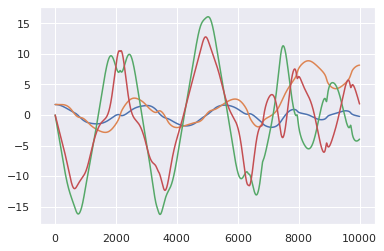

In [4]:
x = vals[:, 0]
y = np.array([a[0] for a in vals[:, 1]])
y1 = np.array([a[1] for a in vals[:, 1]])
y2 = np.array([a[2] for a in vals[:, 1]])
y3 = np.array([a[3] for a in vals[:, 1]])
plt.plot(x, y)
plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, y3)
plt.show()

In [9]:
multi_canvas = MultiCanvas(2, width=800, height=600)
canvas = multi_canvas[0]
dots = multi_canvas[1]
multi_canvas

MultiCanvas(height=600, width=800)

In [10]:
class DrawMayatnik(Thread):
    def __init__ (self, may, mc, v):
        self.mayatnik = may
        self.mcanvas = mc
        self.vals = v
        super(DrawMayatnik, self).__init__()
        
    def run(self):
        for i in self.vals[:, 1]:
            self.mayatnik.render(self.mcanvas[0], i)
            self.mayatnik.dots(self.mcanvas[1], i)
            sleep(0.005)

DrawMayatnik(mayatnik, multi_canvas, vals).start()